In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
cd /content/drive/My Drive/My_Projects/Face_mask

/content/drive/My Drive/My_Projects/Face_mask


# **Data Preprocessing**

In [11]:
import cv2,os
data_path='/content/drive/My Drive/My_Projects/Face_mask/mask_datasets/'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]


In [14]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 100x100, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image


# **Rescale and assign catagorical lables**

In [15]:
import numpy as np
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)
from keras.utils import np_utils
new_target=np_utils.to_categorical(target)

In [16]:
new_target.shape

(1386, 2)

In [19]:
np.save('images.npy',data)
np.save('lables.npy',new_target)

# **CNN Model**

In [22]:
import numpy as np
data=np.load('images.npy')
new_target=np.load('lables.npy')

In [23]:
data.shape

(1386, 100, 100, 1)

In [24]:
data.shape[1:]

(100, 100, 1)

In [25]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(50,activation='relu'))
#Dense layer of 64 neurons
model.add(Dense(2,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 200)       2000      
_________________________________________________________________
activation (Activation)      (None, 98, 98, 200)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 100)       180100    
_________________________________________________________________
activation_1 (Activation)    (None, 47, 47, 100)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 100)       0         
_________________________________________________________________
flatten (Flatten)            (None, 52900)             0

# **Splitting Data into Training and Test**

In [27]:
from sklearn.model_selection import train_test_split
train_data,test_data,train_target,test_target=train_test_split(data,new_target,test_size=0.1)

In [28]:
train_data.shape

(1247, 100, 100, 1)

In [29]:
train_target.shape

(1247, 2)

In [30]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=100,callbacks=[checkpoint],validation_split=0.2)

Epoch 1/100
32/32 [==============================] - 61s 2s/step - loss: 0.9510 - accuracy: 0.5213 - val_loss: 0.6654 - val_accuracy: 0.5400
INFO:tensorflow:Assets written to: model-001.model/assets
Epoch 2/100
32/32 [==============================] - 56s 2s/step - loss: 0.6806 - accuracy: 0.5367 - val_loss: 0.6407 - val_accuracy: 0.7760
INFO:tensorflow:Assets written to: model-002.model/assets
Epoch 3/100
32/32 [==============================] - 56s 2s/step - loss: 0.6131 - accuracy: 0.6895 - val_loss: 0.4837 - val_accuracy: 0.8520
INFO:tensorflow:Assets written to: model-003.model/assets
Epoch 4/100
32/32 [==============================] - 56s 2s/step - loss: 0.4639 - accuracy: 0.8188 - val_loss: 0.2806 - val_accuracy: 0.8720
INFO:tensorflow:Assets written to: model-004.model/assets
Epoch 5/100
32/32 [==============================] - 56s 2s/step - loss: 0.2783 - accuracy: 0.8972 - val_loss: 0.2011 - val_accuracy: 0.9240
INFO:tensorflow:Assets written to: model-005.model/assets
Epoch

In [31]:
from matplotlib import pyplot as plt

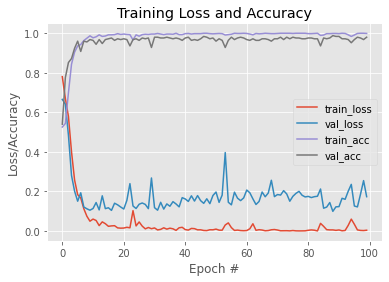

In [32]:
# plot the training loss and accuracy
N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("CNN_Model")